In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt 
from graphviz import Digraph
from IPython.display import display



In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', grad=0.0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        self._backwrard = lambda: None
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backwrard = _backward
        return out
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backwrard = _backward
        return out
    def __pow__(self, other):
        out = Value(self.data ** other, (self,), '^')
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backwrard = _backward
        return out
    def exp(self):
        out=Value(math.exp(self.data),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward=_backward
        return out
    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        def _backward():
            self.grad += out.grad
            other.grad += -1 * out.grad
        out._backwrard = _backward
        return out
    def __rmul__(self,other):
        return self*other
    def __truediv__(self,other):
        return self*(other**-1)
    def __neg__(self):
        return self * -1
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backwrard()

In [4]:
def build(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot=Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges=build(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid,label="{ %s | data %.4f | grad %.4f}"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid + n._op,label=n._op)
            dot.edge(uid + n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

In [5]:
a=Value(1.0,label='a')
b=Value(2.0,label='b')
c=Value(3.0,label='c')
d=a*b
d.label='d'
e=d+c
e.label='e'
f=e*e
f.label='f'
f.backward()

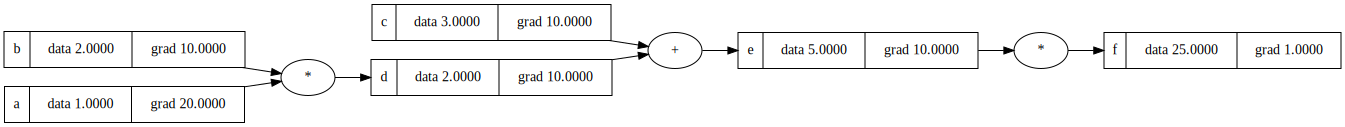

In [6]:
display(draw_dot(f))

In [7]:
import torch
x1=torch.Tensor([2.0]).double();x1.requires_grad_(True)
x2=torch.Tensor([0.0]).double();x2.requires_grad_(True)
w1=torch.Tensor([-3.0]).double();w1.requires_grad_(True)
w2=torch.Tensor([1.0]).double();w2.requires_grad_(True)
b=torch.Tensor([2.0]).double();b.requires_grad_(True)
n=x1*w1 + x2*w2 + b
print("Net input : ",n.item())
o=torch.tanh(n)
print("Output : ",o.item())
print("<------------------->")
print("x1 : ",x1)
print("x2 : ",x2)
print("w1 : ",w1)
print("w2 : ",w2)
print("b : ",b)
print("n : ",n)
print("o : ",o)
o.backward()   
print("<------------------------>")
print("x1 grad",x1.grad.item())
print("x2 grad",x2.grad.item())
print("w1 grad",w1.grad.item())
print("w2 grad",w2.grad.item())
x1

Net input :  -4.0
Output :  -0.999329299739067
<------------------->
x1 :  tensor([2.], dtype=torch.float64, requires_grad=True)
x2 :  tensor([0.], dtype=torch.float64, requires_grad=True)
w1 :  tensor([-3.], dtype=torch.float64, requires_grad=True)
w2 :  tensor([1.], dtype=torch.float64, requires_grad=True)
b :  tensor([2.], dtype=torch.float64, requires_grad=True)
n :  tensor([-4.], dtype=torch.float64, grad_fn=<AddBackward0>)
o :  tensor([-0.9993], dtype=torch.float64, grad_fn=<TanhBackward0>)
<------------------------>
x1 grad -0.004022852049077749
x2 grad 0.0013409506830259165
w1 grad 0.002681901366051833
w2 grad 0.0


tensor([2.], dtype=torch.float64, requires_grad=True)

In [ ]:
class Neuron:
    def __init__(self,nin):
        self.w=[(Value(np.random.uniform(-1,1))) for _ in range(nin)]
        self.b=Value(np.random.uniform(-1,1))
    def __call__(self,x):
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        intermidate=(Value.exp(act)-Value.exp(-act))/(Value.exp(act)+Value.exp(-act))
        return intermidate
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        out=[n(x) for n in self.neurons]
        return out
class MLP:
    def __init__(self,layers,nin):
        sz=[nin]+layers
        print("size : ",sz)
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(layers))]

x_in=np.random.uniform(-5,5,5)
n=Layer(5,5)
n(x_in)

IndentationError: expected an indented block after class definition on line 15 (1404544250.py, line 17)